In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import os
import scipy.io
import scipy.signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
np.random.seed(1337)

In [2]:
low_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\10degC\all_raw.csv"
mid_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\25degC\all_raw.csv"
high_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\40degC\all_raw.csv"

In [3]:
def input_output(files):
    x_train_all = pd.DataFrame()
    x_val_all = pd.DataFrame()
    x_test_all = pd.DataFrame()
    y_train_all = pd.DataFrame()
    y_val_all = pd.DataFrame()
    y_test_all = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file)
        x_df = pd.DataFrame(df[['Voltage', 'Current', 'Temperature']])
        y_df = pd.DataFrame(df['Capacity'])

        x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle=False)
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=False) # 0.25 x 0.8 = 0.2

        x_train_all = pd.concat([x_train_all, x_train], ignore_index=True)
        x_val_all = pd.concat([x_val_all, x_val], ignore_index=True)
        x_test_all = pd.concat([x_test_all, x_test], ignore_index=True)
        y_train_all = pd.concat([y_train_all, y_train], ignore_index=True)
        y_val_all = pd.concat([y_val_all, y_val], ignore_index=True)
        y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)

    return x_train_all, x_val_all, x_test_all, y_train_all, y_val_all, y_test_all


x_train, x_val, x_test, y_train, y_val, y_test = input_output([low_file, mid_file, high_file])

In [4]:
def handle(x_df, y_df):
    x_df.fillna(method='ffill', inplace=True)
    y_df.fillna(method='ffill', inplace=True)
    x_df = (x_df - x_df.min()) / (x_df.max() - x_df.min())
    y_df = (y_df - y_df.min()) / (y_df.max() - y_df.min())

    b, a = scipy.signal.butter(1, 0.001, btype='lowpass', output='ba')
    x_df['Avg. Voltage'] = scipy.signal.filtfilt(b, a, x_df.loc[:,'Voltage'])
    x_df['Avg. Current'] = scipy.signal.filtfilt(b, a, x_df.loc[:,'Current'])
    return x_df, y_df

x_train, y_train = handle(x_train, y_train)
x_val, y_val = handle(x_val, y_val)
x_test, y_test = handle(x_test, y_test)

c:\Users\user\anaconda3\envs\sfdd\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


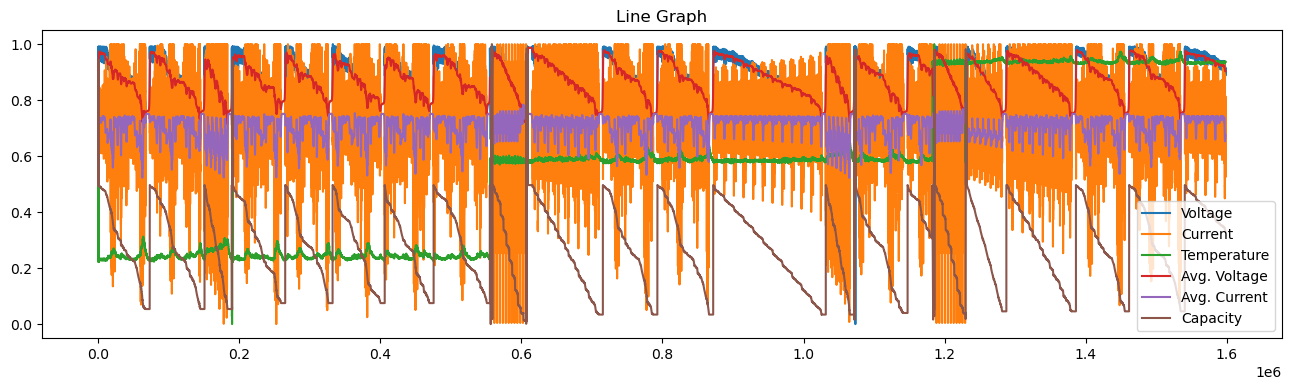

c:\Users\user\anaconda3\envs\sfdd\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


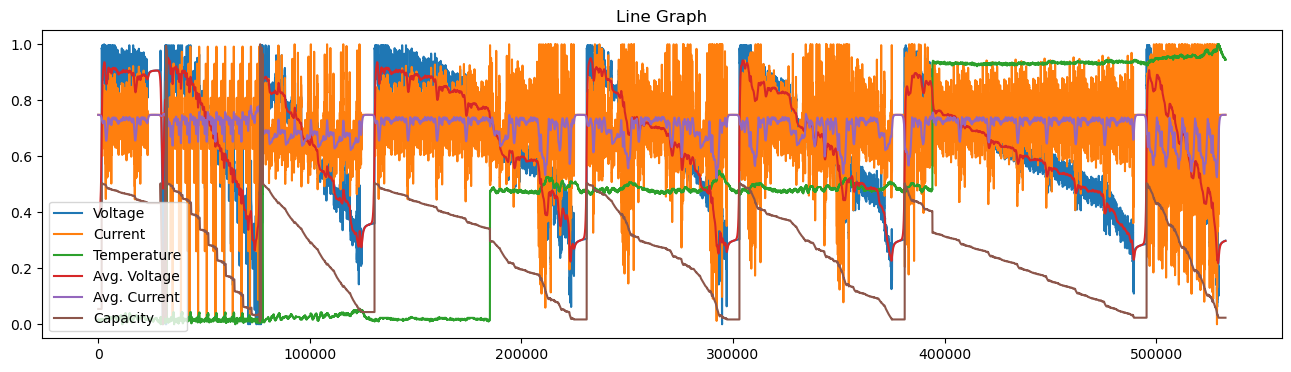

c:\Users\user\anaconda3\envs\sfdd\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


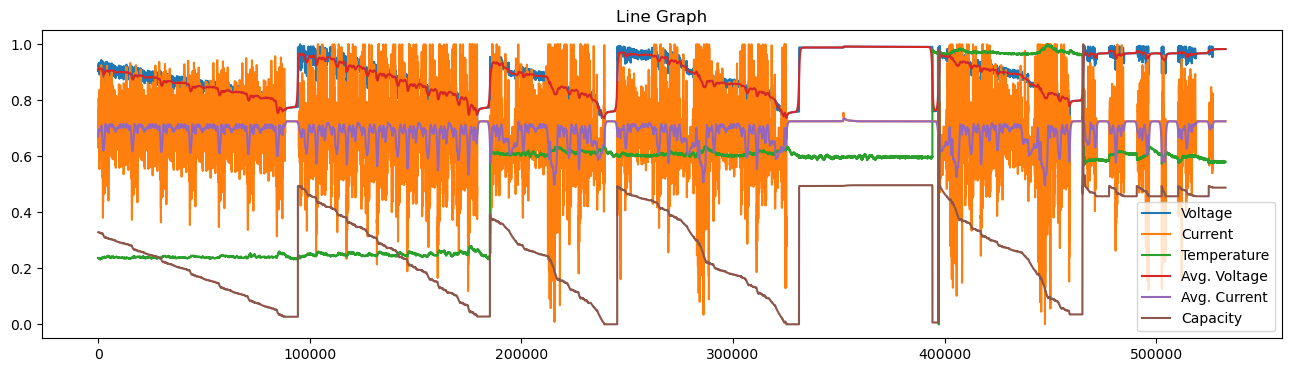

In [5]:
def train_test_plot(x, y):
    df = pd.concat([x, y], axis=1)
    df.iloc[:,0].plot(figsize=(16, 4), legend=True)
    df.iloc[:,1].plot(figsize=(16, 4), legend=True)
    df.iloc[:,2].plot(figsize=(16, 4), legend=True)
    df.iloc[:,3].plot(figsize=(16, 4), legend=True)
    df.iloc[:,4].plot(figsize=(16, 4), legend=True)
    df.iloc[:,5].plot(figsize=(16, 4), legend=True)
    plt.legend(['Voltage', 'Current', 'Temperature', 'Avg. Voltage', 'Avg. Current', 'Capacity'])
    plt.title("Line Graph")
    plt.show()

train_test_plot(x_train, y_train)
train_test_plot(x_val, y_val)
train_test_plot(x_test, y_test)

In [6]:
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(21, activation='tanh'),
  tf.keras.layers.Dense(19, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
  tf.keras.layers.Dense(1, activation=clipped_relu)
])

model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(x_train.values, y_train.values, epochs=100, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)], batch_size=128)

Train on 1598181 samples, validate on 532729 samples
Epoch 1/100
1598181/1598181 [==============================] - 23s 14us/sample - loss: 0.0018 - val_loss: 0.0395
Epoch 2/100
1598181/1598181 [==============================] - 21s 13us/sample - loss: 6.1898e-04 - val_loss: 0.0383
Epoch 3/100
1598181/1598181 [==============================] - 17s 11us/sample - loss: 5.6061e-04 - val_loss: 0.0412


532729/532729 [==============================] - 9s 17us/sample - loss: 0.0020


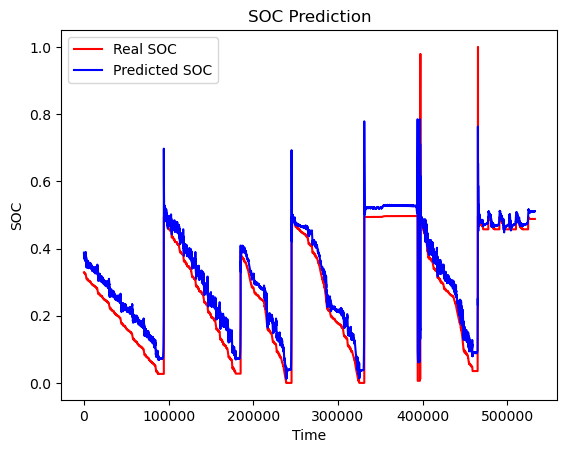

In [8]:
model.evaluate(x_test, y_test)
prediction = model.predict(x_test)

# Visualising the results
plt.plot(y_test, color = 'red', label = 'Real SOC')
plt.plot(prediction, color = 'blue', label = 'Predicted SOC')
plt.title('SOC Prediction')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()
plt.show()

In [9]:
df = pd.read_csv(low_file)
x_df = pd.DataFrame(df[['Voltage', 'Current', 'Temperature']])
y_df = pd.DataFrame(df['Capacity'])

x_df, y_df = handle(x_df, y_df)

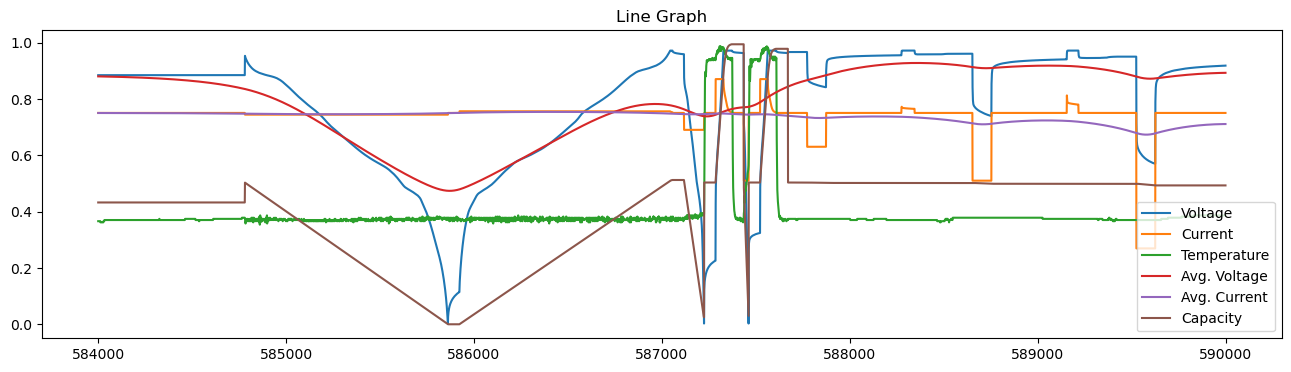

In [10]:
train_test_plot(x_df[584000:590000], y_df[584000:590000])

925533/925533 [==============================] - 15s 17us/sample - loss: 0.0451


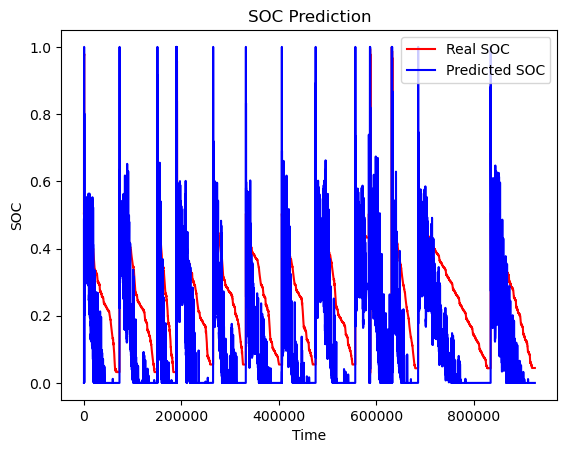

In [13]:
model.evaluate(x_df, y_df)
prediction = model.predict(x_df)

# Visualising the results
plt.plot(y_df, color = 'red', label = 'Real SOC')
plt.plot(prediction, color = 'blue', label = 'Predicted SOC')
plt.title('SOC Prediction')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()
plt.show()